In [ ]:
# outputs includes whole 1-1 part and 1-2-1, 1-2-2

In [1]:
!nvidia-smi

Thu Feb  9 00:26:44 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-PCIE...  Off  | 00000000:3B:00.0 Off |                    0 |
| N/A   26C    P0    23W / 250W |    126MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-PCIE...  Off  | 00000000:D8:00.0 Off |                    0 |
| N/A   

In [2]:
!pip install torchvision==0.9.1
!pip install tqdm


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import numpy as np
import torch.nn as nn
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from sklearn.decomposition import PCA

In [17]:
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
nw = 0
bs = 64
vsize = 0.2

transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

td = datasets.CIFAR10('data', train=True, download=True, transform=transform)
testd = datasets.CIFAR10('data', train=False, download=True, transform=transform)

tl = len(td)
i = list(range(tl))
np.random.shuffle(i)
split = int(np.floor(vsize * tl))
ti, vi = i[split:], i[:split]

training_data = SubsetRandomSampler(ti)
validation_data = SubsetRandomSampler(vi)

train_loader = torch.utils.data.DataLoader(td, batch_size=bs,
    sampler=training_data, num_workers=nw)
valid_loader = torch.utils.data.DataLoader(td, batch_size=bs, 
    sampler=validation_data, num_workers=nw)
test_loader = torch.utils.data.DataLoader(testd, batch_size=bs, 
    num_workers=nw)


classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']
print('debug 2.....')


Files already downloaded and verified
Files already downloaded and verified
debug 2.....


In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # fully connected layers
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 10)
        # dropout
        self.dropout = nn.Dropout(p=.5)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flattening
        x = x.view(-1, 64 * 4 * 4)
        # fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [7]:
model1 = Net()
if train_on_gpu:
  model1.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model1.parameters(), lr=0.01, weight_decay = 0.005, momentum = 0.9) 
print(model1)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [38]:
#--------------------------------pca--------------------------
weights_list = []
weights_list1 = []
train_losslist1 = []
for i in range(8):
    n_epochs = [*range(20)]
    valid_loss_min = np.Inf 
    plt.figure()
    for epoch in range(1, len(n_epochs)+1):
        train_loss = 0.0
        valid_loss = 0.0
        
        model1.train()
        for data, target in train_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            optimizer.zero_grad()
            output = model1(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
        model1.eval()
        #weights = list(model1.parameters())
        #print(weights)
        if (epoch + 1) % 3 == 0:
            weights = []
            weights1=[]
            for name, param in model1.named_parameters():
                if "weight" in name:
                    weights.append(param.data.cpu().numpy().flatten())
            weights = np.concatenate(weights)
            weights_list.append(weights)
            weights1.append(model1.fc1.weight.data.cpu().numpy().flatten())
            weights1 = np.concatenate(weights1)
            weights_list1.append(weights1)
            
        
        for data, target in valid_loader:
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            output = model1(data)
            loss = criterion(output, target)
            valid_loss += loss.item()*data.size(0)
        
        train_loss = train_loss/len(train_loader.dataset)
        valid_loss = valid_loss/len(valid_loader.dataset)
        train_losslist1.append(train_loss)
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
        
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
            torch.save(model1.state_dict(), 'model_cifar.pt')
            valid_loss_min = valid_loss

            
            

Epoch: 1 	Training Loss: 0.601427 	Validation Loss: 0.145250
Validation loss decreased (inf --> 0.145250).  Saving model ...
Epoch: 2 	Training Loss: 0.606379 	Validation Loss: 0.143673
Validation loss decreased (0.145250 --> 0.143673).  Saving model ...
Epoch: 3 	Training Loss: 0.602927 	Validation Loss: 0.149000
Epoch: 4 	Training Loss: 0.605797 	Validation Loss: 0.148678
Epoch: 5 	Training Loss: 0.608253 	Validation Loss: 0.150658
Epoch: 6 	Training Loss: 0.610592 	Validation Loss: 0.146314
Epoch: 7 	Training Loss: 0.602968 	Validation Loss: 0.146054
Epoch: 8 	Training Loss: 0.600615 	Validation Loss: 0.159468
Epoch: 9 	Training Loss: 0.609792 	Validation Loss: 0.143969
Epoch: 10 	Training Loss: 0.604620 	Validation Loss: 0.158460
Epoch: 11 	Training Loss: 0.597011 	Validation Loss: 0.149902
Epoch: 12 	Training Loss: 0.608050 	Validation Loss: 0.145405
Epoch: 13 	Training Loss: 0.595591 	Validation Loss: 0.155291
Epoch: 14 	Training Loss: 0.603008 	Validation Loss: 0.151900
Epoch: 1

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

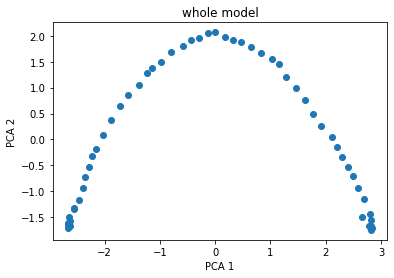

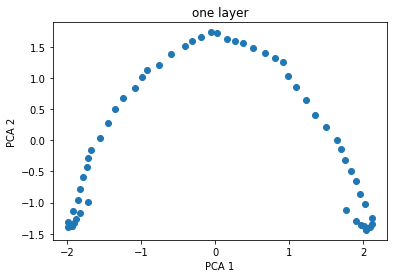

In [40]:
color = ['red', 'blue', 'yellow', 'green', 'orange', 'cyan','black']
pca = PCA(n_components=2)
weights_2d = pca.fit_transform(weights_list)
# Plot pca1 vs pca2 on a graph
plt.scatter(weights_2d[:, 0], weights_2d[:, 1])
plt.title('whole model')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.savefig('whole model weights.png')
plt.show()

pca1 = PCA(n_components=2)
weights_2d1 = pca1.fit_transform(weights_list1)
plt.scatter(weights_2d1[:, 0], weights_2d1[:, 1])
plt.title('one layer')
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.savefig('one layer.png')
plt.show()